# KIRC gene overrepresentation analysis with enrichR


In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(ggtext)
library(matrixStats)
library(msigdbr)
library(fgsea)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




### Functions

In [2]:
fora_test<-function(d,...){
    d <- d %>% 
          distinct(gene_id) 
    res<-fora(pathways = hm_list,
              genes = d$gene_id,
              universe = all_se_genes,
              minSize = 15, 
              maxSize = 250) 
    return(res)
}

### Load TRex results

In [3]:
res_dir <- "../../../chapter2_Methods/2.1_TRexMethod/tcga/output/KIRC/trex/coefs_condition"
cancer<-"KIRC"
analysis<-"condition"

In [4]:
res.files <- list.files(res_dir,pattern = "SE.res.lfcShrink.condition.trex_countA.*",recursive = F)
names(res.files)<-sub("\\.res.*","",res.files)%>%sub("/","_",.)

cond <- lapply(res.files,function(file,...){
                 res <- suppressWarnings(fread(file.path(res_dir,file),data.table=FALSE,stringsAsFactors = F,drop=1,nThread = 4))%>%
                        mutate(signif = padj<0.05) %>%                
                        mutate(cancer=cancer,
                                exp_var=sub(".*trex_countA\\.","",file) %>% sub("\\.tsv","",.)) %>%
                         select(-constitutive_transcripts,-alternative_transcripts,-seqname)    
        }) %>% do.call(rbind,.)%>%
        rename_at(vars(log2FoldChange:padj,signif),function(col){paste0(col,"_condition")} )

In [6]:
tumor.ora<-fread(file = "../input/Figure9_KIRC.res.lfcShrink.condition.trexCount.tsv",data.table = F) %>%
            filter(!na_flag)

In [7]:
imp.ora<-fread(file = "../input/Figure9_KIRC.res.lfcShrink.impurity.trexCount.tsv",data.table=F)%>%
            filter(!na_flag)

In [8]:
gmapfile<-"../input/gencode.v37.primary_assembly.annotation.geneIDmap.tsv"
genemap<-fread(gmapfile,data.table=F)

# Gene overrepresentation analysis 

In [10]:
tumor.ora <- tumor.ora %>% 
             mutate(GENEID=gene_id) %>% 
             left_join(.,genemap) %>% 
             filter(gene_group!="NS",
                    event_flag=="valid",
                    abs(log2FoldChange_condition)!=0)

imp.ora <- imp.ora %>% 
            mutate(GENEID=sub("\\..*","",gene_id)) %>% 
            left_join(.,genemap) %>% 
            filter(padj_impurity<0.05,
                   event_flag=="valid",
                   abs(log2FoldChange_impurity)!=0)

Joining, by = "GENEID"
Joining, by = "GENEID"


In [11]:
### Split data into categories
for(d in c("up","down")){
    
    data<-imp.ora %>% 
            filter(direction==d) %>%
            ungroup() %>%
            distinct(GENENAME)
    write.table(data,file=paste0("../output/tables/Figure9_KIRC.genes.impurity.",d,".tsv"),row.names=F,quote=F,col.names = F,sep="\t")

    for(gg in unique(tumor.ora$gene_group)){
        data<-tumor.ora %>%
              filter(gene_group==gg,
                     direction==d) %>%
              select(GENENAME)
        write.table(data,file=paste0("../output/tables/Figure9_KIRC.genes.condition.",gg,".",d,".tsv"),row.names=F,quote=F,col.names = F,sep="\t")
    }
}

### GORA

Extend this to include impurity-associated changes and potentially intron retention events

In [12]:
hm_gene_sets <- msigdbr(species = "human") %>%
                filter(gs_cat=="H")
hm_df <- hm_gene_sets %>% 
         distinct(gs_cat,gs_name,ensembl_gene) %>%
         as.data.frame() 
hm_list <- split(x = hm_df$ensembl_gene, f = hm_df$gs_name)

In [13]:
all_se_genes<-unique(gsub("\\.\\d*","",cond$gene_id))
message("Universe size: ",length(all_se_genes))

Universe size: 12628



In [14]:
tumor.ora.events<-tumor.ora %>% select(gene_group,event_id,gene_id,direction)
imp.ora.events<-imp.ora %>%
                mutate(gene_group="impurity",
                       gene_id=sub("\\..*","",gene_id)) %>% 
                select(gene_group,event_id,gene_id,direction)

In [15]:
gora.cond <- rbind(tumor.ora.events,imp.ora.events) %>%
             group_by(gene_group,direction) %>%
             tidyr::nest(data = event_id:gene_id) %>%
             mutate(gora_res = lapply(data,fora_test))

gora_res <- gora.cond %>%
            select(-data) %>%
            tidyr::unnest(gora_res)%>% 
            ungroup() %>%
            mutate(significant=padj<0.2)
gord<-gora_res %>%
      select(-overlapGenes) %>%
      group_by(gene_group)%>%
      summarize(n=sum(significant)) %>%
      arrange(n) 

pord<-gora_res %>%
      filter(direction=="up") %>%
      select(-overlapGenes) %>%
      mutate(pathway=sub("HALLMARK_","",pathway)) %>%
      group_by(pathway)%>%
      summarize(n=sum(significant)) %>%
      filter(n!=0) %>%
      arrange(desc(n)) 

gora_res.plt <- gora_res %>%
                mutate(pathway=factor(sub("HALLMARK_","",pathway),levels=pord$pathway),
                       gene_group=factor(gene_group,levels=gord$gene_group),
                       poverlap=round(overlap/size,2)*100,
                       direction=factor(direction,levels=c("up","down"))) %>% 
                filter(pathway%in%pord$pathway)

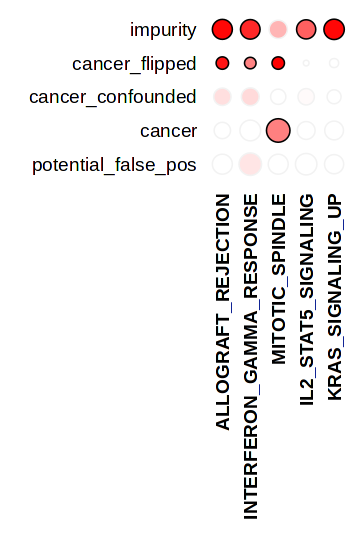

In [16]:
options(repr.plot.width=3,repr.plot.height=4.5)
col.pal <- colorRampPalette(colors = c("#FFFFFF","#FF0000"))
g<-gora_res.plt %>%
    filter(direction=="up")%>%
    mutate(significance=-log10(padj))%>%
    ggplot(.,aes(y=gene_group,x=pathway,fill=significance,color=significant,size=poverlap))+
        geom_point(pch=21)+
        scale_fill_gradientn(colours = col.pal(20))+
        scale_color_manual(values = c("#F2F2F2","#000000"),guide="none")+
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90,color="black",,face="bold",hjust=1,vjust=0.5),
              axis.text.y = element_text(color = "black"),
              plot.background = element_blank(),
              axis.ticks = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              legend.position = "top",
              text = element_text(size=14),
              strip.background = element_blank(),
              strip.text = element_blank())+
        scale_x_discrete(position = "bottom") +
        scale_y_discrete(position = "left") +
        labs(x="",y="")+
        facet_wrap(~direction,ncol=1)

legend<-get_legend(g)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.up.gora.event.categories.pdf",width = 8,height=1,units="in",device="pdf")
g<-g+theme(legend.position="none")
ggsave(plot=g,filename="../output/figures/gora.up.event.categories.pdf",width=3,height=4.5,units="in",device = "pdf")
g

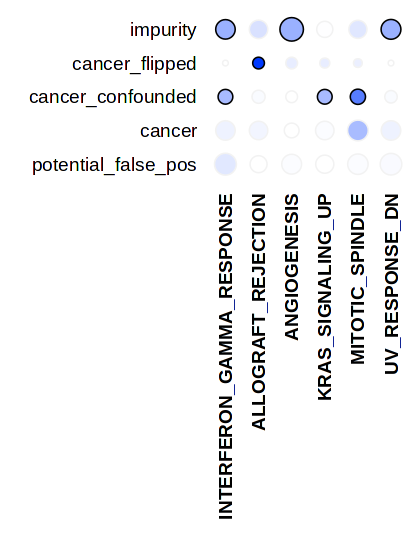

In [17]:
options(repr.plot.width=3.5,repr.plot.height=4.5)
col.pal <- colorRampPalette(colors = c("#FFFFFF","#003AFF"))

pord<-gora_res %>%
      filter(direction=="down") %>%
      select(-overlapGenes) %>%
      mutate(pathway=sub("HALLMARK_","",pathway)) %>%
      group_by(pathway)%>%
      summarize(n=sum(significant)) %>%
      filter(n!=0) %>%
      arrange(desc(n))
gora_res.plt <- gora_res %>%
                mutate(pathway=factor(sub("HALLMARK_","",pathway),levels=pord$pathway),
                       gene_group=factor(gene_group,levels=gord$gene_group),
                       poverlap=round(overlap/size,2)*100,
                       direction=factor(direction,levels=c("up","down"))) %>% 
                filter(pathway%in%pord$pathway)
g<-gora_res.plt %>%
    filter(direction=="down",pathway%in%pord$pathway)%>%
    mutate(significance=-log10(padj))%>%
    ggplot(.,aes(y=gene_group,x=pathway,fill=significance,color=significant,size=poverlap))+
        geom_point(pch=21)+
        scale_fill_gradientn(colours = col.pal(20))+
        scale_color_manual(values = c("#F2F2F2","#000000"),guide="none")+
        theme_bw()+
        theme(axis.text.x = element_text(angle = 90,color="black",,face="bold",hjust=1,vjust=0.5),
              axis.text.y = element_text(color = "black"),
              plot.background = element_blank(),
              axis.ticks = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              legend.position = "top",
              text = element_text(size=14),
              strip.background = element_blank(),
              strip.text = element_blank())+
        scale_x_discrete(position = "bottom") +
        scale_y_discrete(position = "left") +
        labs(x="",y="")+
        facet_wrap(~direction,ncol=1)

legend<-get_legend(g)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.down.gora.event.categories.pdf",width = 8,height=1,units="in",device="pdf")
g<-g+theme(legend.position="none")
ggsave(plot=g,filename="../output/figures/gora.down.event.categories.pdf",width=3.5,height=4.5,units="in",device = "pdf")
g

In [18]:
all_genes<-hm_df %>% 
            filter(gs_name %in% as.character(unique(gora_res[gora_res$significant,]$pathway))) %>%
            select(-gs_cat) %>%
            rename("pathway"="gs_name",
                   "GENEID"="ensembl_gene")

In [19]:
gora_res_signif<-gora_res %>%
                 filter(significant) %>%
                 group_by(gene_group,direction,pathway) %>%
                 tidyr::unnest(overlapGenes) %>%
                 select(overlapGenes) %>%
                 dplyr::rename("GENEID"="overlapGenes") %>%
                 ungroup() %>%
                 distinct(pathway,GENEID) %>%
                 mutate(overlap=1) %>%
                 full_join(.,all_genes) %>%
                 left_join(.,genemap) %>%
                 mutate(overlap=ifelse(is.na(overlap),0,overlap)) %>%
                 distinct(pathway,SYMBOL,overlap) %>%
                 filter(!is.na(SYMBOL))

Adding missing grouping variables: `gene_group`, `direction`, `pathway`
Joining, by = c("pathway", "GENEID")
Joining, by = "GENEID"


### Create C matrix for GEDI

In [20]:
C<-gora_res_signif %>%
    tidyr::pivot_wider(names_from = pathway,values_from = overlap,id_cols = SYMBOL,values_fill = 0) %>%
    tibble::column_to_rownames("SYMBOL") %>%
    as.matrix()

In [21]:
dim(C)

[1] 1044    7

In [22]:
saveRDS(C,file = "../output/objects/KIRC.gora_res.C_matrix.RDS")